In [161]:
import altair as alt
import plotly.express as px

import pandas as pd
import numpy as np


In [162]:
# Payload
measurement_sizes = {
    'Barometer Data': 4,
    'LSM6DSL Acc': 4*3,
    'LSM6DSL Gyro': 4*3,
    'GPS All': 19, # gnss_info(2+4+4+1+1) + gnss_time (7) = 19 bytes 
    'Battery INA260': 4*2, # 8
    '3V3 INA260': 4*2, # 8
    'Radio Temp': 1, # 1
}

groups = {
    'LSM6DSL Acc': ['LSM6DSL Acc'],
    'LSM6DSL Gyro': ['LSM6DSL Gyro'],
    'BMP390': ['Barometer Data'],
    'GPS,Power': ['GPS All', 'Battery INA260', '3V3 INA260', 'Radio Temp']
}

# seconds
stages = [
    ['boost', 3],
    ['flight', 330],
    ['ground', 24*60*60] #one day
]

stage_rates = {
    'boost': {'LSM6DSL Acc': 1000, 'LSM6DSL Gyro': 1000, 'BMP390': 100, 'GPS,Power': 1},
    'flight': {'LSM6DSL Acc': 100, 'LSM6DSL Gyro': 100, 'BMP390': 100, 'GPS,Power': 1},
    'ground': {'LSM6DSL Acc': 1, 'LSM6DSL Gyro': 0, 'BMP390': 1/60, 'GPS,Power': 1/60}
}


timestamp_size_bytes = 4

flash_chip_size_bytes = 128 * 1024 * 1024 / 8


In [163]:
# Deployment Mod
# measurement_sizes = {
#     'BMP390 Temperature': 4,
#     'BMP390 Pressure': 4,
#     'LSM6DSO Acc': 4*3,
#     'LSM6DSO Gyro': 4*3,
#     'MS5611 Press': 4,
#     'MS5611 Temp': 4,
# }
# groups = {
#     'MS5611': ['MS5611 Press', 'MS5611 Temp'],
#     'LSM6DSO': ['LSM6DSO Acc', 'LSM6DSO Gyro'],
#     'BMP390': ['BMP390 Temperature', 'BMP390 Pressure'],
# }

# # ms
# stages = [
#     ['boost', 3],
#     ['ascent', 30],
#     ['flight', 302],
# ]

# stage_rates = {
#     'boost': {'MS5611': 1024, 'LSM6DSO': 416, 'BMP390': 50},
#     'ascent': {'MS5611': 1024, 'LSM6DSO': 208, 'BMP390': 180},
#     'flight': {'MS5611': 512, 'LSM6DSO': 52, 'BMP390': 50},
# }


# timestamp_size_bytes = 4

# flash_chip_size_bytes = 128 * 1024 * 1024

In [164]:
sizedf = pd.DataFrame.from_dict(
    measurement_sizes, orient='index', columns=['size_bytes'])

stageratedf = pd.DataFrame.from_dict(stage_rates).T

stagelendf = pd.DataFrame.from_records(
    stages, columns=['stage', 'time_s'], index='stage')

packetsizedf = pd.DataFrame.from_records([(groupname, sum([measurement_sizes[sensor] for sensor in groups[groupname]]))
                                         for groupname in groups.keys()], columns=['group', 'data'], index='group')
packetsizedf['timestamp'] = timestamp_size_bytes


In [165]:
combined = stageratedf.stack().to_frame(name='read_rate')
combined.index.set_names(['stage', 'group'], inplace=True)

totals = combined.join(packetsizedf) \
    .apply(lambda r: [r['read_rate'] * r['data'], r['read_rate'] * r['timestamp']], axis=1, result_type='expand') \
    .rename(columns={0: 'data', 1: 'timestamp'}).stack().rename('rate').rename_axis(['stage', 'group', 'part']).to_frame()

rates = combined.join(packetsizedf) \
    .apply(lambda r: [r['read_rate'] * r['data'], r['read_rate'] * r['timestamp']], axis=1, result_type='expand') \
    .rename(columns={0: 'data', 1: 'timestamp'}).stack().rename('rate').rename_axis(['stage', 'group', 'part']).to_frame()


In [166]:
packetsizedf['size_with_ts'] = packetsizedf['data']  + packetsizedf['timestamp']

In [167]:
combined


read_rate
stage  group                    
boost  LSM6DSL Acc   1000.000000
       LSM6DSL Gyro  1000.000000
       BMP390         100.000000
       GPS,Power        1.000000
flight LSM6DSL Acc    100.000000
       LSM6DSL Gyro   100.000000
       BMP390         100.000000
       GPS,Power        1.000000
ground LSM6DSL Acc      1.000000
       LSM6DSL Gyro     0.000000
       BMP390           0.016667
       GPS,Power        0.016667

In [168]:
combined['data_byte_rate'] = combined['read_rate'].mul(
    packetsizedf['data'], level=1)
combined['timestamp_byte_rate'] = combined['read_rate'].mul(
    timestamp_size_bytes)
combined['packet_byte_rate'] = combined['read_rate'].mul(
    packetsizedf['size_with_ts'], level=1)


In [169]:
combined

read_rate  data_byte_rate  timestamp_byte_rate  \
stage  group                                                            
boost  LSM6DSL Acc   1000.000000    12000.000000          4000.000000   
       LSM6DSL Gyro  1000.000000    12000.000000          4000.000000   
       BMP390         100.000000      400.000000           400.000000   
       GPS,Power        1.000000       36.000000             4.000000   
flight LSM6DSL Acc    100.000000     1200.000000           400.000000   
       LSM6DSL Gyro   100.000000     1200.000000           400.000000   
       BMP390         100.000000      400.000000           400.000000   
       GPS,Power        1.000000       36.000000             4.000000   
ground LSM6DSL Acc      1.000000       12.000000             4.000000   
       LSM6DSL Gyro     0.000000        0.000000             0.000000   
       BMP390           0.016667        0.066667             0.066667   
       GPS,Power        0.016667        0.600000             0.066667   

                     packet_byte_rate  
stage  group                           
boost  LSM6DSL Acc       16000.000000  
       LSM6DSL Gyro      16000.000000  
       BMP390              800.000000  
       GPS,Power            40.000000  
flight LSM6DSL Acc        1600.000000  
       LSM6DSL Gyro       1600.000000  
       BMP390              800.000000  
       GPS,Power            40.000000  
ground LSM6DSL Acc          16.000000  
       LSM6DSL Gyro          0.000000  
       BMP390                0.133333  
       GPS,Power             0.666667

In [170]:
combined['num_samples'] = combined['read_rate'].mul(
    stagelendf['time_s']).astype(int)
combined['data_total_bytes'] = combined['num_samples'].mul(
    packetsizedf['size_with_ts'], level=1).astype(int)
combined['timestamp_total_bytes'] = combined['num_samples'].mul(
    timestamp_size_bytes).astype(int)
combined['packet_total_bytes'] = combined['data_total_bytes'] + combined['timestamp_total_bytes']

In [171]:

totals = combined.sum().to_frame(
    'total').T[['data_total_bytes', 'timestamp_total_bytes', 'packet_total_bytes']]
totals


,data_total_bytes,timestamp_total_bytes,packet_total_bytes
total,2883240.0,779652.0,3662892.0


In [172]:
def littlefs_overhead(length):
    return length * 1.01 + 2048

In [173]:
overhead = pd.concat([totals.map(lambda x : int(littlefs_overhead(x))).rename({'total': 'Including Overhead (B)'}), \
totals.map(lambda x : int(littlefs_overhead(x))/(1024*1024)).rename({'total': 'Including Overhead (MB)'})])
bytes_used_including_overhead = overhead['packet_total_bytes']['Including Overhead (B)']
overhead = overhead.map(lambda f : f"{f:.3f}")

overhead

,data_total_bytes,timestamp_total_bytes,packet_total_bytes
Including Overhead (B),2914120.000,789496.000,3701568.000
Including Overhead (MB),2.779,0.753,3.530


In [174]:
combined


read_rate  data_byte_rate  timestamp_byte_rate  \
stage  group                                                            
boost  LSM6DSL Acc   1000.000000    12000.000000          4000.000000   
       LSM6DSL Gyro  1000.000000    12000.000000          4000.000000   
       BMP390         100.000000      400.000000           400.000000   
       GPS,Power        1.000000       36.000000             4.000000   
flight LSM6DSL Acc    100.000000     1200.000000           400.000000   
       LSM6DSL Gyro   100.000000     1200.000000           400.000000   
       BMP390         100.000000      400.000000           400.000000   
       GPS,Power        1.000000       36.000000             4.000000   
ground LSM6DSL Acc      1.000000       12.000000             4.000000   
       LSM6DSL Gyro     0.000000        0.000000             0.000000   
       BMP390           0.016667        0.066667             0.066667   
       GPS,Power        0.016667        0.600000             0.066667   

                     packet_byte_rate  num_samples  data_total_bytes  \
stage  group                                                           
boost  LSM6DSL Acc       16000.000000         3000             48000   
       LSM6DSL Gyro      16000.000000         3000             48000   
       BMP390              800.000000          300              2400   
       GPS,Power            40.000000            3               120   
flight LSM6DSL Acc        1600.000000        33000            528000   
       LSM6DSL Gyro       1600.000000        33000            528000   
       BMP390              800.000000        33000            264000   
       GPS,Power            40.000000          330             13200   
ground LSM6DSL Acc          16.000000        86400           1382400   
       LSM6DSL Gyro          0.000000            0                 0   
       BMP390                0.133333         1440             11520   
       GPS,Power             0.666667         1440             57600   

                     timestamp_total_bytes  packet_total_bytes  
stage  group                                                    
boost  LSM6DSL Acc                   12000               60000  
       LSM6DSL Gyro                  12000               60000  
       BMP390                         1200                3600  
       GPS,Power                        12                 132  
flight LSM6DSL Acc                  132000              660000  
       LSM6DSL Gyro                 132000              660000  
       BMP390                       132000              396000  
       GPS,Power                      1320               14520  
ground LSM6DSL Acc                  345600             1728000  
       LSM6DSL Gyro                      0                   0  
       BMP390                         5760               17280  
       GPS,Power                      5760               63360

In [175]:
forDisplay = combined.join(stagelendf).rename(columns={
    'read_rate': 'Sampling Rate (hz)',
    'data_byte_rate': "Data Rate (b/s)",
    'timestamp_byte_rate': "Timestamp Rate (b/s)",
    'packet_byte_rate': "Packet Rate (b/s)",
    'num_samples': 'Total Samples',
    'data_total_bytes': 'Total Sensor Data (b)',
    'timestamp_total_bytes': 'Total Timestamp Data (b)',
    'packet_total_bytes': 'Total Data (b)',
    'time_s': 'Stage Time'
})

forDisplay.set_index(forDisplay.index.map(lambda r: (
    f'{r[0]} ({stagelendf.loc[r[0]]["time_s"]}s)', r[1]))).drop(columns=['Stage Time'])


Sampling Rate (hz)  Data Rate (b/s)  \
stage           group                                               
boost (3s)      LSM6DSL Acc          1000.000000     12000.000000   
                LSM6DSL Gyro         1000.000000     12000.000000   
                BMP390                100.000000       400.000000   
                GPS,Power               1.000000        36.000000   
flight (330s)   LSM6DSL Acc           100.000000      1200.000000   
                LSM6DSL Gyro          100.000000      1200.000000   
                BMP390                100.000000       400.000000   
                GPS,Power               1.000000        36.000000   
ground (86400s) LSM6DSL Acc             1.000000        12.000000   
                LSM6DSL Gyro            0.000000         0.000000   
                BMP390                  0.016667         0.066667   
                GPS,Power               0.016667         0.600000   

                              Timestamp Rate (b/s)  Packet Rate (b/s)  \
stage           group                                                   
boost (3s)      LSM6DSL Acc            4000.000000       16000.000000   
                LSM6DSL Gyro           4000.000000       16000.000000   
                BMP390                  400.000000         800.000000   
                GPS,Power                 4.000000          40.000000   
flight (330s)   LSM6DSL Acc             400.000000        1600.000000   
                LSM6DSL Gyro            400.000000        1600.000000   
                BMP390                  400.000000         800.000000   
                GPS,Power                 4.000000          40.000000   
ground (86400s) LSM6DSL Acc               4.000000          16.000000   
                LSM6DSL Gyro              0.000000           0.000000   
                BMP390                    0.066667           0.133333   
                GPS,Power                 0.066667           0.666667   

                              Total Samples  Total Sensor Data (b)  \
stage           group                                                
boost (3s)      LSM6DSL Acc            3000                  48000   
                LSM6DSL Gyro           3000                  48000   
                BMP390                  300                   2400   
                GPS,Power                 3                    120   
flight (330s)   LSM6DSL Acc           33000                 528000   
                LSM6DSL Gyro          33000                 528000   
                BMP390                33000                 264000   
                GPS,Power               330                  13200   
ground (86400s) LSM6DSL Acc           86400                1382400   
                LSM6DSL Gyro              0                      0   
                BMP390                 1440                  11520   
                GPS,Power              1440                  57600   

                              Total Timestamp Data (b)  Total Data (b)  
stage           group                                                   
boost (3s)      LSM6DSL Acc                      12000           60000  
                LSM6DSL Gyro                     12000           60000  
                BMP390                            1200            3600  
                GPS,Power                           12             132  
flight (330s)   LSM6DSL Acc                     132000          660000  
                LSM6DSL Gyro                    132000          660000  
                BMP390                          132000          396000  
                GPS,Power                         1320           14520  
ground (86400s) LSM6DSL Acc                     345600         1728000  
                LSM6DSL Gyro                         0               0  
                BMP390                            5760           17280  
                GPS,Power                         5760           63360

In [185]:
forDisplay[['Total Data (b)']].groupby('stage').sum()

,Total Data (b)
stage,
boost,123732
flight,1730520
ground,1808640


In [176]:
totals2 = combined[['data_total_bytes', 'timestamp_total_bytes', 'packet_total_bytes']] \
    .rename(columns={'data_total_bytes': 'data', 'timestamp_total_bytes': 'timestamp', 'packet_total_bytes': 'packet'}) \
    .stack() \
    .rename('total') \
    .rename_axis(['stage', 'group', 'part']) \
    .to_frame()

rates = combined[['data_byte_rate', 'timestamp_byte_rate', 'packet_byte_rate']] \
    .rename(columns={'data_byte_rate': 'data', 'timestamp_byte_rate': 'timestamp', 'packet_byte_rate': 'packet'}) \
    .stack() \
    .rename('rate') \
    .rename_axis(['stage', 'group', 'part']) \
    .to_frame()


In [177]:
noind = totals2.join(rates).reset_index()
parts = noind[noind['part'] != 'packet'].set_index(['stage', 'group', 'part'])

In [178]:
parts.unstack()


total                    rate             
part                    data timestamp          data    timestamp
stage  group                                                     
boost  BMP390           2400      1200    400.000000   400.000000
       GPS,Power         120        12     36.000000     4.000000
       LSM6DSL Acc     48000     12000  12000.000000  4000.000000
       LSM6DSL Gyro    48000     12000  12000.000000  4000.000000
flight BMP390         264000    132000    400.000000   400.000000
       GPS,Power       13200      1320     36.000000     4.000000
       LSM6DSL Acc    528000    132000   1200.000000   400.000000
       LSM6DSL Gyro   528000    132000   1200.000000   400.000000
ground BMP390          11520      5760      0.066667     0.066667
       GPS,Power       57600      5760      0.600000     0.066667
       LSM6DSL Acc   1382400    345600     12.000000     4.000000
       LSM6DSL Gyro        0         0      0.000000     0.000000

In [179]:
with_unused = parts.copy()
with_unused['usage'] = 'used'
with_unused = with_unused.reset_index().set_index(['usage', 'stage', 'group', 'part'])
with_unused = pd.concat([with_unused, pd.DataFrame([('unused', 'unused', 'unused', 'unused', flash_chip_size_bytes - bytes_used_including_overhead, 0)], columns=["usage", "stage", "group", "part", "total", "rate"]).set_index(['usage', 'stage', 'group', 'part'])])

In [180]:
fig = px.sunburst(with_unused.reset_index(), path=[
                  'usage','stage', 'group', 'part'], values='total', title=f"Data Usage of {int(flash_chip_size_bytes // 1024 // 1024)}MB")
fig.show()


In [187]:
bytes_used_including_overhead/(1024*1024)

np.float64(3.53009033203125)

In [181]:
with_unused.head(1)

,,,,total,rate
usage,stage,group,part,,
used,boost,LSM6DSL Acc,data,48000.0,12000.0


<Axes: ylabel='Total Bytes'>

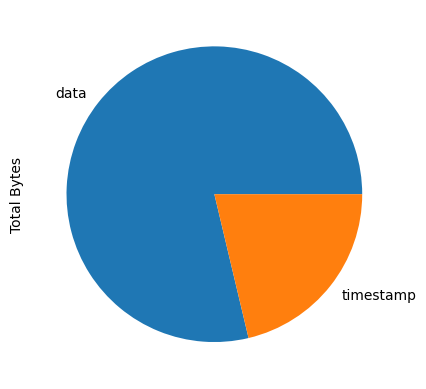

In [182]:
with_unused[with_unused['rate'] != 0].reset_index().drop(columns=['usage']).groupby('part').sum().rename(columns={'total':'Total Bytes'}).plot(kind='pie', y='Total Bytes', legend=False)

<Axes: ylabel='Total Bytes'>

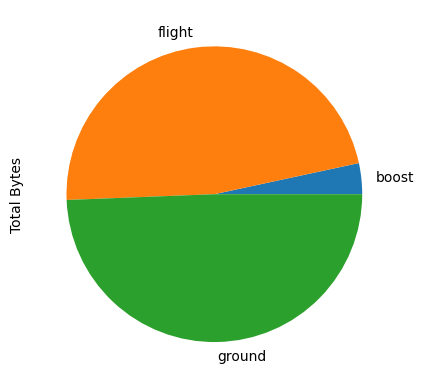

In [183]:
with_unused[with_unused['rate'] != 0].reset_index().drop(columns=['usage']).groupby('stage').sum().rename(columns={'total':'Total Bytes'}).plot(kind='pie', y='Total Bytes', legend=False)